In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize

## Преобразование Бокса-Кокса

In [2]:
data = pd.read_csv('passengers.csv', index_col='date', parse_dates = True)
passengers=data["num_passengers"]


In [21]:
passengers

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: num_passengers, Length: 144, dtype: int64

In [3]:
def fun(y, lam):
    if lam == 0:
        return np.log(y)
    else:
        return (y**lam - 1) / lam

In [4]:
def box_cox(y, lam):
    return -(y.size/2) * np.log(np.sum((fun(y,lam)- fun(y,lam).mean())**2 )/ y.size) + (lam - 1) * np.sum(np.log(y))

In [5]:
result = minimize(lambda x: -box_cox(passengers, x), 1)
lamda=result.x
result

      fun: 679.5431311684138
 hess_inv: array([[0.03868383]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([0.14802242])

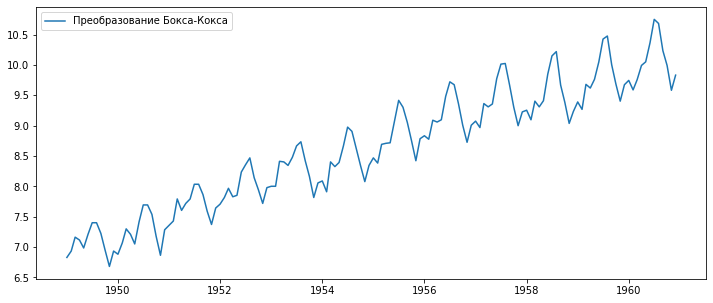

In [6]:
plt.figure(figsize = (12, 5))
plt.plot(fun(passengers, lamda), label = 'Преобразование Бокса-Кокса')
plt.legend()
plt.show()

In [7]:
box_c=fun(passengers, lamda)
y_out_seas=[] #сезонное дифференцировнаие
for i in range (0,len(box_c)-12):
    y_out_seas.append(box_c[i+12]-box_c[i])

In [8]:
y_out_trend=[] #обычное дифференцировнаие
for i in range (0,len(y_out_seas)-1):
    y_out_trend.append(y_out_seas[i+1]-y_out_seas[i])

можно было делать через .diff(12) для датафрейма

чтобы проверить стационарность можно использовать критерий дикки-фуллера. adfuller или построить автокорреляцию

## AR

In [9]:
matrix=np.array([y_out_trend[11:-1],y_out_trend[10:-2],y_out_trend[0:-12]]).transpose()

In [10]:
def fun1(fi1,fi2,fi3):
    return np.mean((y_out_trend[12:]-matrix.dot(np.array([fi1,fi2,fi3])))**2)

In [11]:
result=minimize(lambda x: fun1(x[0],x[1],x[2]), (0,0,0))
fi1_fi2_fi3=result.x
result

      fun: 0.007465219947682396
 hess_inv: array([[51.53600709, 21.60813585, -4.52279731],
       [21.60813585, 41.79571544,  6.03521183],
       [-4.52279731,  6.03521183, 47.97731842]])
      jac: array([ 4.03966988e-06, -6.48049172e-06,  2.41940143e-06])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 12
     njev: 16
   status: 0
  success: True
        x: array([-0.370362  , -0.03520214, -0.40606924])

In [12]:
y_pred=matrix.dot(fi1_fi2_fi3)

.dropna()  - выкидывает из данных строки где хотя бы в одном столбце нан

## Составим прогноз

In [13]:
prognoz=[]
y_pred_new=y_pred

In [14]:
for i in range (12):
    m=y_pred_new[-1]*fi1_fi2_fi3[0]+y_pred_new[-2]*fi1_fi2_fi3[1]+y_pred_new[-12]*fi1_fi2_fi3[2]
    prognoz.append(m)
    y_pred_new=np.append(y_pred_new,m)



## Обратные преобразования

In [15]:
y_with_trend=[] #обычное дифференцировнаие
for i in range (len(y_pred_new)):
    y_with_trend.append(y_pred_new[i]+y_out_seas[i+1])

In [16]:
y_with_seas=[] #сезонное дифференцировнаие
for i in range (len(y_with_trend)):
    y_with_seas.append(y_with_trend[i]+box_c[i+12])

In [17]:
def fun2(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return (y*lam + 1) **(1/lam)

In [18]:
date_start=passengers.index[-1]+pd.DateOffset(years=1) #формируем столбец новых дат с 2017-2027
date_end=date_start+pd.DateOffset(years=10)
dates=pd.date_range(date_start,date_end,freq='YS')
new_dates=pd.DataFrame(dates)
new_dates.columns=['date']
new_dates=new_dates.set_index('date')

nn = np.empty(11) # строки с 2017-2027 заполним nan
nn.fill(np.nan)
new_df = pd.concat([passengers, new_dates]) #объединяем в единый DataFrame

In [19]:
sarima = pd.Series(data = fun2(y_with_seas,lamda), index = pd.date_range(passengers.index[25],periods=131,freq="MS"))

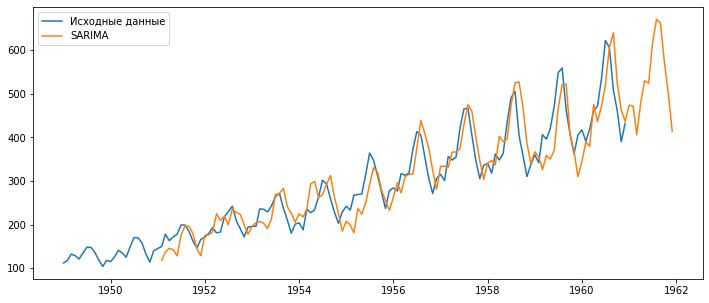

In [20]:
plt.figure(figsize = (12, 5))
plt.plot(passengers, label = 'Исходные данные')
plt.plot(sarima, label = 'SARIMA')
plt.legend()
plt.show()